In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/philippe/MolGenDocking


/home/philippe/miniconda3/envs/MolGen/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
FIG_PATH = "/home/philippe/-Philippe-MolGenDocking/Figures/results"

In [3]:
from pathlib import Path
import json
import re

import pandas as pd
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import DataStructs

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster

from notebooks.utils import PandasTableFormatter
from mol_gen_docking.reward.diversity_aware_top_k import diversity_aware_top_k

In [135]:
MOLSTRAL_PATH = Path("MolGenOutput/polaris_eval")

files = [f for f in MOLSTRAL_PATH.iterdir() if "error" not in str(f) and str(f).endswith("scored.jsonl")]
files = sorted(files)

In [136]:
MODEL_META = {
    "ether0": {
        "size":"24B",
        "thinking": True,
        "Chem.": True,
    },
    "molstral": {
        "size":"24B",
        "thinking": True,
        "Chem.": True,
    },
    "ChemDFM-v2.0": {
        "thinking": False,
        "Chem.": True,
    },
    "ChemDFM-R": {
        "thinking": True,
        "Chem.": True,
    },
    "-R1-": {
        "thinking": True,
        "Chem.": False,
    },
    "Llama-3.3": {
        "thinking": False,
        "Chem.": False,
    },
    "Qwen3-30B-A3B-Thinking": {
        "thinking": True,
        "Chem.": False,
    },
    "gemma-3": {
        "thinking": False,
        "Chem.": False,
    },
}

In [137]:
table.properties.unique()

array(['tdcommons/ames', 'tdcommons/clearance-hepatocyte-az',
       'tdcommons/clearance-microsome-az',
       'tdcommons/cyp2c9-substrate-carbonmangels',
       'tdcommons/cyp3a4-substrate-carbonmangels',
       'tdcommons/half-life-obach', 'tdcommons/ld50-zhu',
       'tdcommons/lipophilicity-astrazeneca',
       'tdcommons/solubility-aqsoldb', 'tdcommons/vdss-lombardo',
       'asap-discovery/antiviral-potency-2025-unblinded',
       'biogen/adme-fang-hclint-reg-v1', 'biogen/adme-fang-hppb-reg-v1',
       'biogen/adme-fang-perm-reg-v1', 'biogen/adme-fang-rclint-reg-v1',
       'biogen/adme-fang-rppb-reg-v1', 'biogen/adme-fang-solu-reg-v1',
       'novartis/novartis-cyp3a4-v1', 'polaris/az-logd-74-v1',
       'polaris/az-ppb-clearance-v1',
       'polaris/drewry2017-pkis2-subset-v2', 'tdcommons/bbb-martins',
       'tdcommons/caco2-wang', 'tdcommons/cyp2d6-substrate-carbonmangels',
       'tdcommons/dili', 'tdcommons/herg', 'tdcommons/pgp-broccatelli'],
      dtype=object)

In [138]:
PROP_NAME = {
    # ASAP
    "asap-discovery/antiviral-potency-2025-unblinded": "antiviral-potency",

    # Biogen ADME (FANG)
    "biogen/adme-fang-hclint-reg-v1": "fang-hclint",
    "biogen/adme-fang-hppb-reg-v1": "fang-hppb",
    "biogen/adme-fang-perm-reg-v1": "fang-perm",
    "biogen/adme-fang-rclint-reg-v1": "fang-rclint",
    "biogen/adme-fang-rppb-reg-v1": "fang-rppb",
    "biogen/adme-fang-solu-reg-v1": "fang-solubility",

    # Novartis
    "novartis/novartis-cyp3a4-v1": "cyp3a4-novartis",

    # Polaris / AZ
    "polaris/az-logd-74-v1": "az-logd",
    "polaris/az-ppb-clearance-v1": "az-ppb-clearance",
    "polaris/drewry2017-pkis2-subset-v2": "pkis2-drewry",

    # Therapeutics Data Commons (TDC)
    "tdcommons/ames": "ames",
    "tdcommons/bbb-martins": "bbb",
    "tdcommons/caco2-wang": "caco2",
    "tdcommons/clearance-hepatocyte-az": "hep-clearance-az",
    "tdcommons/clearance-microsome-az": "mic-clearance-az",
    "tdcommons/cyp2c9-substrate-carbonmangels": "cyp2c9-substrate",
    "tdcommons/cyp2d6-substrate-carbonmangels": "cyp2d6-substrate",
    "tdcommons/cyp3a4-substrate-carbonmangels": "cyp3a4-substrate",
    "tdcommons/dili": "dili",
    "tdcommons/half-life-obach": "half-life",
    "tdcommons/herg": "herg",
    "tdcommons/ld50-zhu": "ld50",
    "tdcommons/lipophilicity-astrazeneca": "lipophilicity",
    "tdcommons/pgp-broccatelli": "pgp",
    "tdcommons/solubility-aqsoldb": "solubility",
    "tdcommons/vdss-lombardo": "vdss",
}


In [139]:
generations = []
size_pattern = re.compile(r'(?i)(?:^|[-_])(\d+\s*[b])(?:$|[-_])')

for f in tqdm(files):
    with f.open("r") as fd:
        for i_l,line in enumerate(fd):
            g = json.loads(line)
            all_smis = g["reward_meta"].get("all_smi", [""])
            fail_reason = "valid"
            if len(all_smis) == 0:
                valid = 0
                smiles = ""
                reward = 0.
                fail_reason = g["reward_meta"].get("smiles_extraction_failure", "unknown").replace("_", " ").replace("smiles", "SMILES")
            elif len(all_smis) > 1:
                valid = 1
                smiles = all_smis[-1]
                reward = float(g["reward_meta"]["all_smi_rewards"][-1])
            else:
                valid = 1
                smiles = all_smis[0]
                reward = float(g["reward"])
            model_name = str(f).split("/")[-1].split("eval")[0][:-1]
            if "scored" in model_name:
                model_name = str(f).split("/")[-1].split("scored")[0][:-2]

            assert any([m in model_name for m in MODEL_META.keys()])
            key = [m for m in MODEL_META.keys() if m in model_name][0]
            model_metadata = MODEL_META[key]
            if not "size" in model_metadata:
                try:
                    size = size_pattern.search(model_name).group(1).upper()
                except:
                    raise ValueError(f"Size not found for model {model_name}")
            else:
                size = model_metadata["size"]
            thinking = r"\CheckmarkBold" if model_metadata["thinking"] else r"\XSolidBrush"
            chem = r"\CheckmarkBold" if model_metadata["Chem."] else r"\XSolidBrush"

            generations.append(
                {
                    "prompt_id": g["metadata"]["prompt_id"],
                    "reward": reward,
                    "model": model_name,
                    "n_props": len(g["metadata"]["properties"]),
                    "properties": ",".join(g["metadata"]["properties"]),
                    "objectives": ",".join(g["metadata"]["objectives"]),
                    "smiles":smiles,
                    "validity": valid,
                    "valid": fail_reason,
                    "Size": size,
                    "Think.": thinking,
                    "Task": PROP_NAME[",".join(g["metadata"]["properties"])]
                }
            )

df = pd.DataFrame(generations)
df["gen_id"] = df.index % 3
df

100%|██████████| 28/28 [00:57<00:00,  2.04s/it]


,prompt_id,reward,model,n_props,properties,objectives,smiles,validity,valid,Size,Think.,Task,gen_id
0,tdcommons:half-life-obach_train_1,0.071250,ChemDFM-R-14B_,1,tdcommons/half-life-obach,regression,,1,valid,14B,\CheckmarkBold,half-life,0
1,tdcommons:half-life-obach_train_1,0.833693,ChemDFM-R-14B_,1,tdcommons/half-life-obach,regression,,1,valid,14B,\CheckmarkBold,half-life,1
2,tdcommons:half-life-obach_train_1,0.000000,ChemDFM-R-14B_,1,tdcommons/half-life-obach,regression,,1,valid,14B,\CheckmarkBold,half-life,2
3,tdcommons:half-life-obach_train_115,0.864323,ChemDFM-R-14B_,1,tdcommons/half-life-obach,regression,,1,valid,14B,\CheckmarkBold,half-life,0
4,tdcommons:half-life-obach_train_115,0.775327,ChemDFM-R-14B_,1,tdcommons/half-life-obach,regression,,1,valid,14B,\CheckmarkBold,half-life,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
757303,polaris:az-logd-74-v1_train_29,0.000000,gemma-3-27b-it_,1,polaris/az-logd-74-v1,regression,,1,valid,27B,\XSolidBrush,az-logd,1
757304,polaris:az-logd-74-v1_train_29,0.000000,gemma-3-27b-it_,1,polaris/az-logd-74-v1,regression,,1,valid,27B,\XSolidBrush,az-logd,2
757305,polaris:az-logd-74-v1_train_2687,0.995578,gemma-3-27b-it_,1,polaris/az-logd-74-v1,regression,,1,valid,27B,\XSolidBrush,az-logd,0
757306,polaris:az-logd-74-v1_train_2687,0.000000,gemma-3-27b-it_,1,polaris/az-logd-74-v1,regression,,1,valid,27B,\XSolidBrush,az-logd,1


In [140]:
table = df.groupby(["gen_id", "model", "properties", "Size", "Think.", "objectives", "Task"]).reward.mean().reset_index()

table["Model"] = table["model"].apply(lambda x: re.sub(r"-\d+(B|b)", "", x).replace("-2507", "").replace("Distill", "D.").replace("-it", "").replace("Thinking", "Think."))
MODEL_ORDER = [
    "Qwen3-A3B-Think.",
    "DeepSeek-R1-D.-Llama",
    "DeepSeek-R1-D.-Qwen",
    "gemma-3",
    "Llama-3.3-Instruct",
    "ChemDFM-R",
    "ether0",
    "ChemDFM-v2.0",
]
table["Model"] = table["Model"].apply(lambda x: x.replace("_", ""))
table

,gen_id,model,properties,Size,Think.,objectives,Task,reward,Model
0,0,ChemDFM-R-14B_,asap-discovery/antiviral-potency-2025-unblinded,14B,\CheckmarkBold,regression,antiviral-potency,0.000253,ChemDFM-R
1,0,ChemDFM-R-14B_,biogen/adme-fang-hclint-reg-v1,14B,\CheckmarkBold,regression,fang-hclint,0.157437,ChemDFM-R
2,0,ChemDFM-R-14B_,biogen/adme-fang-hppb-reg-v1,14B,\CheckmarkBold,regression,fang-hppb,0.250308,ChemDFM-R
3,0,ChemDFM-R-14B_,biogen/adme-fang-perm-reg-v1,14B,\CheckmarkBold,regression,fang-perm,0.401313,ChemDFM-R
4,0,ChemDFM-R-14B_,biogen/adme-fang-rclint-reg-v1,14B,\CheckmarkBold,regression,fang-rclint,0.064060,ChemDFM-R
...,...,...,...,...,...,...,...,...,...
379,2,gemma-3-27b-it_,tdcommons/dili,27B,\XSolidBrush,classification,dili,0.392739,gemma-3
380,2,gemma-3-27b-it_,tdcommons/half-life-obach,27B,\XSolidBrush,regression,half-life,0.370878,gemma-3
381,2,gemma-3-27b-it_,tdcommons/herg,27B,\XSolidBrush,classification,herg,0.595694,gemma-3
382,2,gemma-3-27b-it_,tdcommons/ld50-zhu,27B,\XSolidBrush,regression,ld50,0.004203,gemma-3


/tmp/ipykernel_771473/1804920710.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(rotation=90, ha='center', labels=ax.get_xticklabels())
/tmp/ipykernel_771473/1804920710.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(rotation=90, ha='center', labels=["Avg."])
/tmp/ipykernel_771473/1804920710.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(rotation=90, ha='center', labels=ax.get_xticklabels())
/tmp/ipykernel_771473/1804920710.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(rotation=90, ha='center', labels=["Avg."])


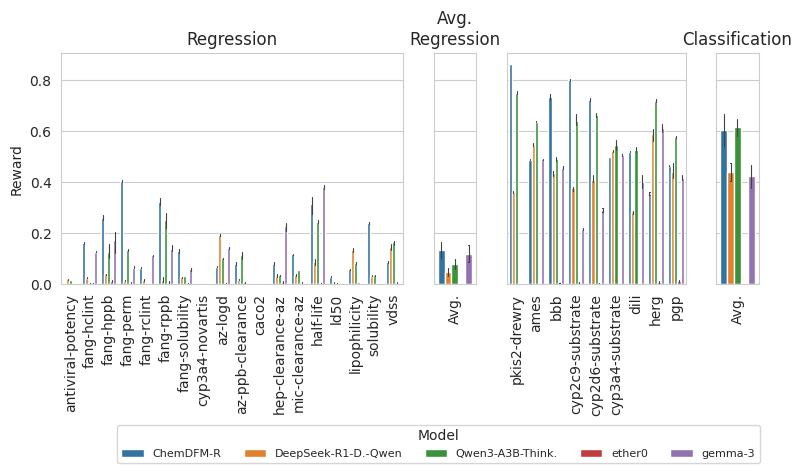

In [164]:
ax_size_ratio = table[table.objectives == "regression"].shape[0] / table.shape[0]
avg_ratio = ax_size_ratio/8
fig, axes = plt.subplots(
    1,
    4,
    figsize = (9,3),
    sharey=True,
    gridspec_kw = {"width_ratios":[ax_size_ratio, avg_ratio, 1-ax_size_ratio,  avg_ratio]}
)

ax = axes[0]
sns.barplot(
    data=table[table.objectives == "regression"],
    x="Task",
    y="reward",
    hue="Model",
    ax=ax,
    legend=False,
    capsize=.02,
    err_kws={"linewidth": .8},
)
ax.set_xlabel("")
ax.set_ylabel("Reward")
ax.set_xticklabels(rotation=90, ha='center', labels=ax.get_xticklabels())
ax.set_title("Regression")

ax = axes[1]
sns.barplot(
    data=table[table.objectives == "regression"],
    x="objectives",
    y="reward",
    hue="Model",
    ax=ax,
    legend=False,
    capsize=.02,
    err_kws={"linewidth": .8},
)
ax.set_xlabel("")
ax.set_xticklabels(rotation=90, ha='center', labels=["Avg."])
ax.set_title("Avg.\nRegression")

ax = axes[2]
sns.barplot(
    data=table[table.objectives == "classification"],
    x="Task",
    y="reward",
    hue="Model",
    ax=ax,
    legend=False,
    capsize=.02,
    err_kws={"linewidth": .8},
)
ax.set_xlabel("")
ax.set_xticklabels(rotation=90, ha='center', labels=ax.get_xticklabels())

ax = axes[3]
sns.barplot(
    data=table[table.objectives == "classification"],
    x="objectives",
    y="reward",
    hue="Model",
    ax=ax,
    capsize=.02,
    err_kws={"linewidth": .8},
)
ax.set_xlabel("")
ax.set_xticklabels(rotation=90, ha='center', labels=["Avg."])
ax.set_title("Avg.\nClassification")


ax.legend(title="Model", loc="lower center", bbox_to_anchor=(-6.5, -.8), ncols = 8, fontsize = 8, title_fontsize = 10)

ax.set_title("Classification")
fig.savefig(f"{FIG_PATH}/molecular_proppred.pdf", bbox_inches="tight")

In [29]:
table.Model.unique()

array(['DeepSeek-R1-D.-Qwen', 'Qwen3-A3B-Think.', 'ether0'], dtype=object)

In [30]:
LATEX_PATH = "/home/philippe/-Philippe-MolGenDocking/tables"

In [90]:
formatter = PandasTableFormatter(
    n_decimals = 3, # Number of decimals to keep in the table
    aggregation_methods=["mean", "std"], # Aggregation functions to apply to the data
    main_subset=0, # Subset of values to bold, here the first column will be bolded corresponding to the mean values, if [0,1] the first two columns will be bolded (independently)
    hide_agg_labels=True, # Hide the aggregation column names in the latex
    global_agg=False # Whether to compute global aggregation across all columns (True)
)

style = formatter.style(
    table, # Dataframe to format
    rows= ["Model", "Size", "Think."], # Rows
    cols="Task", # Columns
    values= "reward", # Values
    highlight_fn= np.nanmax, # Function to use to highlight the values, here the maximum values will be highlighted
    props=["font-weight: bold; text-decoration: underline;"], # Properties to apply to the highlighted values, here the maximum values will be underlined and bolded, the second maximum values will be bolded
    special_format_agg = {
        "std": lambda x: "\\tiny $\\pm$" + x, # Format to apply to the standard deviation values
    },
    remove_col_names=False,
    # row_order = MODEL_ORDER
)
style

In [ ]:

formatter.save_to_latex(style, f"{LATEX_PATH}/gen_table.tex", 1, multicol_align="|c|", hrules=True, n_first_cols=2)
style

In [ ]:
formatter = PandasTableFormatter(
    n_decimals = 3, # Number of decimals to keep in the table
    aggregation_methods=["mean", "std"], # Aggregation functions to apply to the data
    main_subset=0, # Subset of values to bold, here the first column will be bolded corresponding to the mean values, if [0,1] the first two columns will be bolded (independently)
    hide_agg_labels=True, # Hide the aggregation column names in the latex
    global_agg=False # Whether to compute global aggregation across all columns (True)
)

style = formatter.style(
    table, # Dataframe to format
    rows= ["Model", "Size", "Think."], # Rows
    cols=["Metric", r"N_rolls"], # Columns
    values= "Value", # Values
    highlight_fn= np.nanmax, # Function to use to highlight the values, here the maximum values will be highlighted
    props=["font-weight: bold; text-decoration: underline;", "text-decoration: underline;"], # Properties to apply to the highlighted values, here the maximum values will be underlined and bolded, the second maximum values will be bolded
    special_format_agg = {
        "std": lambda x: "\\tiny $\\pm$" + x, # Format to apply to the standard deviation values
    },
    remove_col_names=True,
    row_order = MODEL_ORDER
)
formatter.save_to_latex(style, f"{LATEX_PATH}/gen_table_std.tex", 1, multicol_align="|c|", hrules=True, n_first_cols=2)